In [1]:
__author__ = 'David Nidever <dnidever@noao.edu>, Knut Olsen <kolsen@noao.edu>, Robert Nikutta <rnikutta@noao.edu>, Stephanie Juneau <sjuneau@noao.edu>' # single string; emails in <>
__version__ = '20180105' # yyyymmdd; version datestamp of this notebook
__datasets__ = ['nsc_dr1']  # enter used datasets by hand

# Dwarf galaxies in NSC DR1
Find dwarf galaxies in the NSC

<a class="anchor" id="import"></a>
# Imports and setup

In [131]:
# Python 2/3 compatibility
from __future__ import print_function # to use print() as a function in Python 2

try:
    input = raw_input # use 'input' function in both Python 2 and 3
except NameError:
    pass

# std lib
from getpass import getpass

# 3rd party
import pandas as pd
import numpy as np
import pylab as plt
import matplotlib
from astropy import utils, io, convolution, stats, wcs
from astropy.visualization import make_lupton_rgb
from astropy import units as u
from astropy.stats import median_absolute_deviation as mad
%matplotlib inline
import healpy as hp

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers

#Simple Image Access (SIA) service
from pyvo.dal import sia
DEF_ACCESS_URL = "http://datalab.noao.edu/sia"
svc = sia.SIAService(DEF_ACCESS_URL)

# Quiet the Astropy warnings
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

<a class="anchor" id="auth"></a>
# Authentication

In [30]:
# Either get token for anonymous user
token = ac.login('anonymous')

# Authenticated users please uncomment the next line
#token = ac.login(input("Enter user name: "),getpass("Enter password: "))

In [31]:
# A function to retrieve data from a point on the sky
def getData (ra,dec,radius=1.0,columns='*'):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [83]:
# A function to retrieve data from a point on the sky
def getBlueStarData (ra,dec,radius=1.0,columns='ra,dec,gmag,rmag',colcutlo=None,colcuthi=None,classcut=None,fwhmcut=None,errcut=None):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""
    #   (gmag-rmag)>({4:f}) and (gmag-rmag)<{5:f} and class_star>{6:f} and
    #   fwhm<{7:f} and gerr<{8:f} and rerr<{8:f}

    query = query_template.format(columns,ra,dec,radius,colcutlo,colcuthi,classcut,fwhmcut,errcut)
    if colcutlo is not None: query+=" and (gmag-rmag)>("+"{0:f}".format(colcutlo)+")"
    if colcuthi is not None: query+=" and (gmag-rmag)<"+"{0:f}".format(colcuthi)
    if classcut is not None: query+=" and class_star>"+"{0:f}".format(classcut)
    if fwhmcut is not None: query+=" and fwhm<"+"{0:f}".format(fwhmcut)
    if errcut is not None: query+=" and gerr<"+"{0:f}".format(errcut)
    if errcut is not None: query+=" and rerr<"+"{0:f}".format(errcut)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [107]:
# A function to retrieve data from a point on the sky
def getCovData (ra,dec,radius=1.0,columns='*'):

    query_template = \
    """SELECT {0:s} FROM nsc_dr1.coverage
       WHERE q3c_radial_query(ra,dec,{1:f},{2:f},{3:f})"""

    query = query_template.format(columns,ra,dec,radius)
    print(query)
    
    try:
        result = qc.query(token,sql=query) # by default the result is a CSV formatted string
    except Exception as e:
        print(e.message)
        
    df = helpers.convert(result,'pandas')
    
    return df

In [33]:
# A Mexican-hat convolution filter
def dwarf_filter (ra,dec,fwhm_small=2.0,fwhm_big=20):

    # Based on Koposov et al. (2008).
    # Code by Ken Mighell and Mike Fitzpatrick.
    # Minor edits by Rorbert Nikutta.
    
    x, y = ra, dec

    # Information about declination (y) [degrees]
    ymean = (y.min() + y.max()) / 2.0
    ydiff_arcmin = (y.max() - y.min()) * 60.0 # convert from degrees to arcmin

    # Information about right ascension (x) [degrees in time]:
    xdiff = x.max() - x.min() # angular separation [degrees (time)] 
    xmean = (x.min() + x.max())/2.0

    # convert from degrees in time to separation in angular degrees:
    xdiff_angular = (x.max() - x.min()) * np.cos(ymean*(np.pi/180.0))

    # convert from degress to arcmin
    xdiff_angular_arcmin = xdiff_angular * 60.0 

    # Get the number of one-arcmin pixels in the X and Y directions:
    nx = np.rint (xdiff_angular_arcmin).astype('int')
    ny = np.rint (ydiff_arcmin).astype('int')
    
    # Create a two-dimensional histogram of the raw counts:
    Counts, xedges, yedges  = np.histogram2d (x, y, (nx,ny) )
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    raw_hist = np.rot90(Counts).copy() # hack around Pythonic weirdness

    # Make the small and big Gaussian kernels with a standard deviation
    # of the given FWHM in arcmin^2 pixels.
    kernel_small = convolution.Gaussian2DKernel(fwhm_small/2.35,factor=1)
    kernel_big = convolution.Gaussian2DKernel(fwhm_big/2.35,factor=1)

    # Compute the differential convolution kernels.
    conv_big = convolution.convolve (raw_hist, kernel_big)
    conv_small = convolution.convolve (raw_hist, kernel_small)
    conv_delta = conv_small - conv_big
    delta = conv_delta.copy()

    # Compute statistics and the floor
    mean = np.mean (delta, dtype='float64')
    sigma = np.std (delta, dtype='float64')
    sigmaRaw = np.std(raw_hist,dtype='float64')
    median = np.median (delta)                       # not used
    floor = mean 

    # Clip to specified limits.
    clipped = delta.copy()
    clipped[ delta < floor ] = floor

    # Return the computed fields.
    return raw_hist, extent, delta, clipped, sigma

In [34]:
# A little function to download the deepest stacked images
#   adapted from R. Nikutta
def download_deepest_image(ra,dec,fov=0.1,band='g'):
    imgTable = svc.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).votable.to_table()
    print("The full image list contains", len(imgTable), "entries")
    
    sel0 = imgTable['obs_bandpass'].astype(str)==band
    sel = sel0 & ((imgTable['proctype'].astype(str)=='Stacked') & (imgTable['prodtype'].astype(str)=='image')) # basic selection
    Table = imgTable[sel] # select
    if (len(Table)>0):
        row = Table[np.argmax(Table['exptime'].data.data.astype('float'))] # pick image with longest exposure time
        url = row['access_url'].decode() # get the download URL
        print ('downloading deepest image...')
        image = io.fits.getdata(utils.data.download_file(url,cache=True,show_progress=False,timeout=120))

    else:
        print ('No image available.')
        image=None
        
    return image

In [35]:
# Multi panel image plotter
def plot_images(images,geo=None,panelsize=4,bands=list('gri'),cmap=matplotlib.cm.gray_r):
    n = len(images)
    if geo is None: geo = (n,1)
        
    fig = plt.figure(figsize=(geo[0]*panelsize,geo[1]*panelsize))
    for j,img in enumerate(images):
        ax = fig.add_subplot(geo[1],geo[0],j+1)
        if img is not None:
            print(img.min(),img.max())
            vmin = np.median(img)-2*np.std(img)
            vmax = np.median(img)+2*np.std(img)
            ax.imshow(img,origin='lower',interpolation='none',cmap=cmap,norm=matplotlib.colors.LogNorm(vmin=vmin, vmax=vmax))
            ax.set_title('%s band' % bands[j])
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)

<a class="anchor" id="chapter1"></a>
# Step 1 - Pull the data from NSC object table

In [92]:
# Locations of Dwarfs from McConnachie et al. (2012), Bechtol et al. (2015) and others
#ra = [86.4,260.1,185.43,56.09]
#dec = [34.7,-22.2,-31.99,-43.53]
#name = ['Draco','Carina','Hya II','Eri II']
#radius = 0.85 # degrees
#columns = '''ra,dec,gmag,gerr,imag,rmag,zmag,class_star,fwhm'''
#df_dict = {dwarf: pd.DataFrame() for dwarf in name}
#ra0 = 86.4
#dec0 = 34.7
#ra0 = 260.1
#dec0 = -22.2
ra0 = 185.43
dec0 = -31.99
radius = 1.0

In [89]:
#df0 = getData(ra0,dec0,radius=0.01)
#print(str(len(df0))+' objects found')
df = getBlueStarData(ra0,dec0,radius=radius,colcutlo=-0.2,colcuthi=0.8,classcut=0.6,fwhmcut=1.5,errcut=0.1)
print(str(len(df))+' objects found')

SELECT ra,dec,gmag,rmag FROM nsc_dr1.object
       WHERE q3c_radial_query(ra,dec,185.430000,-31.990000,1.000000) and (gmag-rmag)>(-0.200000) and (gmag-rmag)<0.800000 and class_star>0.600000 and fwhm<1.500000 and gerr<0.100000 and rerr<0.100000
Returning Pandas dataframe
22757 objects found


In [128]:
# Get coverage information
cov = getCovData(ra0,dec0,radius=0.1,columns='ra,dec,pix128,gcoverage,gdepth,rcoverage,rdepth')
print(str(len(cov))+' coverage pixels returned')

SELECT ra,dec,pix128,gcoverage,gdepth,rcoverage,rdepth FROM nsc_dr1.coverage
       WHERE q3c_radial_query(ra,dec,185.430000,-31.990000,0.100000)
Returning Pandas dataframe
150 coverage pixels returned


# Step 2 - Make density map
We convolve the result with the spatial filter defined above.

In [94]:
# Create a WCS for a tangent plane projection in our region
def get_wcs(ra,dec,image,fov=1.,unit='deg',projection=("RA---TAN","DEC--TAN")):
    npix = image.shape[0]
    crpix = npix/2 + 1
    cdelt = fov/float(npix)
    w = wcs.WCS(naxis=2)
    w.wcs.cunit = (unit,unit)
    w.wcs.crpix = (crpix,crpix)
    w.wcs.cdelt = np.array((-cdelt,cdelt))
    w.wcs.ctype = projection
    w.wcs.crval = (ra,dec) #coords.ra.to(unit).value, coords.dec.to(unit).value)
    return w

In [151]:
# Create the healpix map
NSIDE = 4096
map = np.arange(hp.nside2npix(NSIDE))
map[:] = hp.UNSEEN   # all unseen/masked to start
#map_masked = hp.ma(map)
#map_masked.mask = np.logical_not(mask)

In [145]:
objpix = hp.pixelfunc.ang2pix(NSIDE,df['ra'],df['dec'],lonlat=True)
objpix

0        155287773
1        155320543
2        155287774
3        155304159
4        155402471
5        155402472
6        155402473
7        155353314
8        155369699
9        155369701
10       155336930
11       155320544
12       155304160
13       155304160
14       155287776
15       155304161
16       155287777
17       155304162
18       155336931
19       155320546
20       155320546
21       155336932
22       155320547
23       155320546
24       155304163
25       155304163
26       155304163
27       155287778
28       155304163
29       155304163
           ...    
22727    152781077
22728    152781077
22729    152764693
22730    152748306
22731    152748307
22732    152764691
22733    152781076
22734    152764692
22735    152764692
22736    152764691
22737    152748307
22738    152731923
22739    152748308
22740    152731922
22741    152748307
22742    152748307
22743    152715539
22744    152715539
22745    152764692
22746    152764693
22747    152764693
22748    152

In [165]:
map[objpix] = 0
map[objpix] += 1
npix = hp.nside2npix(NSIDE)
hist,bin_edges = np.histogram(objpix,bins=npix,range=[0,npix-1])

In [166]:
print(hist)
print(len(hist))
print(npix)

[0 0 0 ..., 0 0 0]
201326592
201326592


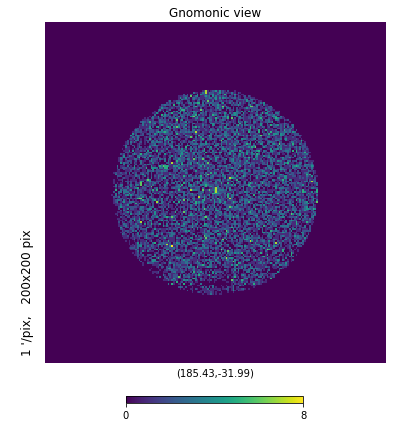

In [167]:
hp.gnomview(hist,reso=1.0,rot=[ra0,dec0],min=0)

In [ ]:
# 20 and 2 arcmin
map1 = hp.sphtfunc.smoothing(hist,fwhm=(20./60.)

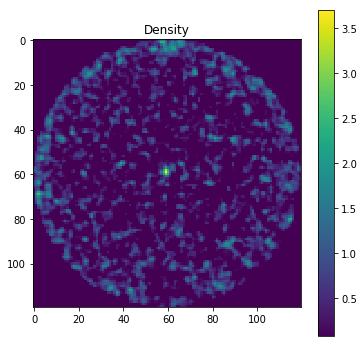

In [101]:
raw_hist, extent, delta, clipped, sigma = dwarf_filter(df['ra'],df['dec'])
#skyPlot(df2,ax)
w = get_wcs(ra0,dec0,clipped,fov=radius)
fig = plt.figure(figsize=(6,6))
#ax = fig.add_subplot(0,0,0,projection=w)
im = plt.imshow(clipped)
plt.colorbar()
plt.title('Density')

# Step 3 - Run Peak Finder
Find the statistically significant peaks